<a href="https://colab.research.google.com/github/vadim1334/---Python/blob/main/telegram_booster_based_on_gigachat_gits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Библиотеки

In [ ]:
#необходимые библиотеки

import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import uuid  #для RqUID
import urllib3
from tqdm import tqdm

##Параметры

TGSTAT_TOKEN = <TGSTAT_TOKEN>

In [ ]:
#отключаем ворнинги про небезопасный SSL
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

GIGACHAT_AUTH_KEY = "<GIGACHAT_AUTH_KEY>"


def get_gigachat_token(scope: str = "GIGACHAT_API_PERS") -> str:
    """
    Запрашивает OAuth-токен для GigaChat по quickstart'у Сбера.
    Возвращает access_token (строка).
    """
    url = <GIGACHAT_TOKEN_URL

    payload = {'scope': scope}
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Accept': 'application/json',
        'RqUID': str(uuid.uuid4()),
        'Authorization': f'Basic {GIGACHAT_AUTH_KEY}',
    }

    #КЛЮЧЕВОЕ: verify=False — ровно как в документации
    resp = requests.post(url, headers=headers, data=payload, timeout=30, verify=False)
    resp.raise_for_status()
    data = resp.json()
    token = data.get("access_token")
    if not token:
        print("Ответ без access_token:", data)
    return token


GIGACHAT_ACCESS_TOKEN = get_gigachat_token()
print("TOKEN:", GIGACHAT_ACCESS_TOKEN[:20], "...")

TOKEN: eyJjdHkiOiJqd3QiLCJl ...


In [ ]:
def gigachat_chat(system_prompt: str,
                  user_prompt: str,
                  model: str = "GigaChat",
                  temperature: float = 0.1,
                  max_tokens: int = 100) -> str:
    url = "https://gigachat.devices.sberbank.ru/api/v1/chat/completions"

    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {GIGACHAT_ACCESS_TOKEN}",
        "Content-Type": "application/json",
    }

    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        "temperature": temperature,
        "max_tokens": max_tokens,
    }

    resp = requests.post(url, json=payload, headers=headers, timeout=60, verify=False)
    resp.raise_for_status()
    data = resp.json()
    return data["choices"][0]["message"]["content"].strip()

## Функция для поиска бизнес-каналов по AI

здесь надо написать искомые слова. Сохраняйте синтаксис

In [ ]:
#расширенный поиск
BUSINESS_QUERIES = [
"финтех",
"корпоративные финансы",
"банковская аналитика",
"комплаенс",
"платежные решения"
]
PRODUCT_QUERIES = [
    "ЮKassa",
    "CloudPayments",
    "PayKeeper",
    "Aplaut",
    "Модульбанк",
    "Тинькофф Бизнес",
    "Альфа-Бизнес",
    "СберБизнес"
]
SEARCH_QUERIES = BUSINESS_QUERIES + AI_QUERIES

## Вспомогательные функции (HTTP, категории ограничений, GPT-классификатор enterprise, генерация ad_text)

здесь надо внести свой промт для отбора каналов. #системный промт для классификации enterprise/B2B, в моем случае </br>
system = (
    "Ты — дата-ассистент для корпоративных задач. "
    "Если канал реально для бизнеса, enterprise/B2B, технологий для компаний — ответь 'yes'. "
    "Если бытовой, массовый, стартап, инфоцыгане, лайфстайл или совсем не по тематике — 'no'. "
    "Ответ строго — только yes или no, ничего лишнего."
)
</br> А также найти и переписать под себя задаваемые условия для промта <br> def generate_ad_text(title, description):
    prompt = (
        f"Ты — копирайтер для B2B рекламы. Сформулируй краткий рекламный текст для Jay Copilot — корпоративная AI-платформа с управляемым доступом к нейросетям, усиливает дефицитных специалистов и избавляет команду от теневого AI. "
        f"Сделай уникальный текст под тематику канала. "
        f"Название: '{title}'. Описание: '{description}'. "
        f"Текст — не длиннее 160 символов, деловой стиль, желательно с призывом к действию, без восклицательных знаков."
    )
    try:

In [ ]:
def safe_get_json(url, params):
    resp = requests.get(url, params=params)
    try:
        resp.raise_for_status()
        return resp.json() if resp.text else {}
    except Exception as e:
        print(f"Ошибка запроса {url} с params={params}: {e}")
        print("Ответ:", resp.text)
        return {}

def group_restr(val):
    if pd.isna(val) or val == "[]" or val == "" or val == [] or val == {} or str(val).lower() == "null":
        return "OK"
    if "red_label" in str(val):
        return "red_label"
    return "Other restrictions"

In [ ]:
#системный промт для классификации enterprise/B2B
system = (
    "Ты — дата-ассистент для корпоративных задач. "
    "Если канал реально для бизнеса, enterprise/B2B, технологий для компаний — ответь 'yes'. "
    "Если бытовой, массовый, стартап, инфоцыгане, лайфстайл или совсем не по тематике — 'no'. "
    "Ответ строго — только yes или no, ничего лишнего."
)


def gpt_enterprise_check(title, description: str = "") -> bool:
    """
    Возвращает True, если канал B2B/enterprise по версии GigaChat, иначе False.
    """
    prompt = (
        f"Название: «{title}». Описание: «{description}». "
        f"Это бизнес-канал для специалистов и компаний (B2B/enterprise) или нет?"
    )
    try:
        answer = gigachat_chat(
            system_prompt=system,
            user_prompt=prompt,
            model="GigaChat",      # или "GigaChat-Pro", если включен
            temperature=0.1,
            max_tokens=3,
        ).lower()
        return answer.strip() == "yes"
    except Exception as e:
        print("Ошибка в gpt_enterprise_check:", e)
        return False

In [ ]:
def generate_ad_text(title: str, description: str) -> str:
    """
    Генерирует короткий рекламный текст под канал.
    """
    prompt = (
        "Ты — копирайтер для B2B рекламы. Сформулируй краткий рекламный текст "
        "для Jay Copilot — корпоративная AI-платформа с управляемым доступом к нейросетям, "
        "усиливает дефицитных специалистов и избавляет команду от теневого AI. "
        "Сделай уникальный текст под тематику канала. "
        f"Название: '{title}'. Описание: '{description}'. "
        "Текст — не длиннее 160 символов, деловой стиль, желательно с призывом к действию, "
        "без восклицательных знаков."
    )
    try:
        text = gigachat_chat(
            system_prompt="Ты — профессиональный B2B-маркетолог.",
            user_prompt=prompt,
            model="GigaChat",
            temperature=0.65,
            max_tokens=100,
        )
        return text
    except Exception as e:
        print(f"Ошибка генерации текста для {title}: {e}")
        return ""

Поиск каналов в TGStat и первичный DataFrame

In [ ]:
channels, channels_seen = [], set()

for q in SEARCH_QUERIES:
    url = "https://api.tgstat.ru/channels/search"
    params = {"token": TGSTAT_TOKEN, "q": q, "country": "ru", "limit": 50}

    resp = safe_get_json(url, params)

    # --- Fallback: TGStat вернул ошибку или пустоту ---
    if not resp or resp.get("status") == "error":
        print(f"[TGSTAT ERROR] query='{q}' →", resp.get("error") if resp else "empty response")
        continue

    items = resp.get("response", {}).get("items", [])
    if not items:
        print(f"[TGSTAT EMPTY] query='{q}' → no items returned")
        continue

    # --- Парсим каналы ---
    for item in items:
        try:
            channel_id = item.get("id")
            if channel_id in channels_seen:
                continue

            tg_link = (
                item.get("link")
                or (f"https://t.me/{item['username']}" if item.get("username") else None)
            )

            channels.append({
                "title": item.get("title") or "",
                "subscribers": item.get("participants_count", 0),
                "created_at": item.get("created_at"),
                "link": tg_link,
                "ci_index": item.get("ci_index", 0),
                "tgstat_restrictions": item.get("tgstat_restrictions"),
                "description": item.get("description") or ""
            })

            channels_seen.add(channel_id)

        except Exception as e:
            print(f"[PARSE ERROR] query='{q}', item={item} → {e}")
            continue


# --- Постобработка ---
if not channels:
    raise ValueError("TGStat не вернул ни одного канала. Проверь токен и лимиты API.")

df = pd.DataFrame(channels)

# created_at → datetime → YYYY-MM-DD
df['created_at'] = pd.to_datetime(df['created_at'], unit='s', errors='coerce').dt.strftime('%Y-%m-%d')

# Сортировка
df_sorted = df.sort_values(by='subscribers', ascending=False, ignore_index=True)

# Переименуем столбцы — безопасно
df_sorted = df_sorted.rename(columns={
    'ci_index': 'ci_index (индекс цитируемости — показатель перепостов/влияния)',
    'tgstat_restrictions': 'tgstat_restrictions (ограничения/блокировки)'
})

# страховка: наличие description
if 'description' not in df_sorted.columns:
    df_sorted['description'] = ""

df = df_sorted  # ← финальный DataFrame
print("Собрано каналов:", len(df))


[TGSTAT EMPTY] query='бизнес для корпораций' → no items returned
[TGSTAT EMPTY] query='корпоративная трансформация' → no items returned
[TGSTAT EMPTY] query='продуктовый мнеджмент' → no items returned
Собрано каналов: 605


In [ ]:
df

,title,subscribers,created_at,link,ci_index (индекс цитируемости — показатель перепостов/влияния),tgstat_restrictions (ограничения/блокировки),description
0,OKX Новости,6094112,2019-09-17,t.me/okx_ru,104.401000,[],
1,TikTokModCloud ☁️,2884687,2021-02-03,t.me/TikTokModCloud,79.591700,[],
2,GPT | ChatGPT | Midjourney — GPTMain News,2237768,2022-03-16,t.me/GPTMainNews,199.520000,{'red_label': True},
3,"Hi, AI • Новости технологий",1987575,2023-09-17,t.me/hiaimedia,70.209200,[],
4,"Цифровой Журнал | IT, Neiroseti",1668474,2022-11-25,t.me/chatgptv,699.479000,[],
...,...,...,...,...,...,...,...
600,ChatGPT Enterprise,2,2024-03-15,t.me/GPT_Enterprise,0.000000,[],
601,OpenSource в Enterprise,2,2019-03-11,t.me/openprise,0.001799,[],
602,Финтех,2,2020-02-10,t.me/graph_in,0.813413,[],
603,Экосистема финтех,1,2021-03-24,t.me/kdwfintech,0.158855,[],


Все уникальные варианты и их количество в поле ограничений:


,count
tgstat_restrictions (ограничения/блокировки),
[],582
{'red_label': True},23


/tmp/ipython-input-156451112.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.isna(val) or val == "[]" or val == "" or val == [] or val == {} or str(val).lower() == "null":


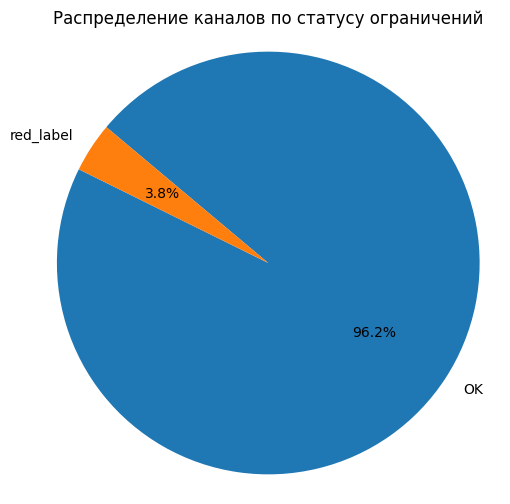

In [ ]:
column = 'tgstat_restrictions (ограничения/блокировки)'
if column not in df.columns:
    column = 'tgstat_restrictions'

restr_str = df[column].astype(str)
restr_counts = restr_str.value_counts(dropna=False)
print("Все уникальные варианты и их количество в поле ограничений:")
display(restr_counts)

df['restriction_cat'] = df[column].apply(group_restr)

# Визуализация
cat_counts = df['restriction_cat'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%', startangle=140, counterclock=False)
plt.title('Распределение каналов по статусу ограничений')
plt.axis('equal')
plt.show()

##Фильтруем каналы с блокировками/ограничениями

## Почему мы фильтруем ограниченные/заблокированные каналы для бизнес-анализа Telegram

*Бизнес-задачи требуют максимально прозрачной и «живой» базы для анализа рынка Telegram-каналов.*

**Если канал ограничен или заблокирован (`tgstat_restrictions`), это значит:**
- Он недоступен новым подписчикам или невидим в каталоге
- Его активность и охват резко снижаются (или обнуляются)


**Фильтрация таких каналов необходима, чтобы:**
- Исключить неактуальные/мёртвые объекты из аналитики
- Оставить в списке только реально рабочие и потенциально безопасные площадки
- Получать объективную картину конкуренции и отрасли для:  
  - выбора каналов для рекламы  
  - проведения мониторинга  
  - оценки динамики рынка

---

### Что происходит дальше с нашими данными?

1. Мы собираем каналы по нужным ключевым словам.
2. Исключаем все каналы с любыми признаками ограничений или блокировок (`tgstat_restrictions`).
3. Сортируем результат по количеству подписчиков — от самых крупных к менее крупным.
4. Выводим таблицу, где видны:
    - название канала
    - количество подписчиков
    - дата создания (год-месяц-день)
    - ссылка
    - индекс цитируемости (ci_index) — косвенный уровень «авторитетности» канала
    - статус ограничений (чтобы убедиться, что всё чисто)

---

**Итого:**  
Блокированные и ограниченные каналы теряют ценность для бизнеса и рекламы, а их анализ может привести к ошибочным решениям. Поэтому предварительный фильтр по этим признакам — must-have для любой деловой, маркетинговой или исследовательской задачи.



Фильтр enterprise/B2B каналов через GPT

In [ ]:
from tqdm import tqdm

def _safe_str(x):
    try:
        return str(x) if x is not None else ""
    except:
        return ""


enterprise_flags = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Enterprise check"):
    title = _safe_str(row.get("title"))
    desc  = _safe_str(row.get("description"))
    try:
        is_b2b = gpt_enterprise_check(title, desc)
    except Exception as e:
        print("[CHECK ERROR]", title, "→", e)
        is_b2b = False
    enterprise_flags.append(is_b2b)

df['enterprise_b2b'] = enterprise_flags
df = df[df['enterprise_b2b']].reset_index(drop=True)
print(f"Осталось enterprise-каналов: {len(df)}")

Enterprise check: 100%|██████████| 605/605 [08:06<00:00,  1.24it/s]

Осталось enterprise-каналов: 391


$$
\boxed{
\text{Trust_Score}_i = \frac{1}{2} \left(
\frac{\text{Subscribers}_i - \min(\text{Subscribers})}{\max(\text{Subscribers}) - \min(\text{Subscribers})}
+
\frac{\text{CI_index}_i - \min(\text{CI_index})}{\max(\text{CI_index}) - \min(\text{CI_index})}
\right)
}
$$


## Trust_score = (нормированные_подписчики + нормированный_ci_index) / 2



## Как считается интегральный индекс доверия канала (trust_score)?

1. **Берём два показателя для каждого канала:**
   - Общее количество подписчиков
   - Индекс цитируемости (ci_index) — насколько часто канал упоминают или репостят

2. **Приводим оба числа к одному масштабу — делаем их «от 0 до 1»:**
   - Минимальное значение становится 0, максимальное — 1, все остальные пропорционально между ними.

3. **Cкладываем их и делим пополам (берём среднее):**
   - Итоговый балл = (Нормированные подписчики + Нормированный ci_index) / 2

**Чем выше итоговый балл (от 0 до 1) — тем канал и массовый, и влиятельный сразу.  
В топ попадут те каналы, которые одновременно и крупные по подписчикам, и активно цитируемые/репостимые.**

---

### Пример на числах (картинка для гуманитариев):

- У канала 50 000 подписчиков, а у самого крупного — 1 000 000, у самого маленького — 100:
  - Его «нормированные подписчики»: (50 000 − 100) / (1 000 000 − 100) ≈ 0.05
- ci_index для этого канала — 10, а минимальный по всей базе — 0, максимальный — 200:
  - Его нормированный ci_index: (10 − 0) / (200 − 0) = 0.05
- Индекс доверия = (0.05 + 0.05) / 2 = **0.05**

---

**Формула в одну строку (без «страшных» математических знаков):**




In [ ]:
# Приведение типов
df['ci_index (индекс цитируемости — показатель перепостов/влияния)'] = pd.to_numeric(
    df['ci_index (индекс цитируемости — показатель перепостов/влияния)'], errors='coerce').fillna(0)
df['subscribers'] = pd.to_numeric(df['subscribers'], errors='coerce').fillna(0)

# Нормализация 0..1
subs_min, subs_max = df['subscribers'].min(), df['subscribers'].max()
ci_min = df['ci_index (индекс цитируемости — показатель перепостов/влияния)'].min()
ci_max = df['ci_index (индекс цитируемости — показатель перепостов/влияния)'].max()

# чтобы избежать деления на ноль, если все одинаковы
def minmax(series, vmin, vmax):
    if pd.isna(vmin) or pd.isna(vmax) or vmin == vmax:
        return pd.Series([0.0]*len(series), index=series.index)
    return (series - vmin) / (vmax - vmin)

df['subscribers_norm'] = minmax(df['subscribers'], subs_min, subs_max)
df['ci_index_norm'] = minmax(df['ci_index (индекс цитируемости — показатель перепостов/влияния)'], ci_min, ci_max)

# Среднее по двум признакам
df['trust_score'] = 0.5 * df['subscribers_norm'] + 0.5 * df['ci_index_norm']

# Сортировка по убыванию доверия
df_trust = df.sort_values(by='trust_score', ascending=False).reset_index(drop=True)
display(df_trust[['title','link','subscribers','ci_index (индекс цитируемости — показатель перепостов/влияния)','trust_score','created_at']].head(10))

,title,link,subscribers,ci_index (индекс цитируемости — показатель перепостов/влияния),trust_score,created_at
0,"Цифровой Журнал | IT, Neiroseti",t.me/chatgptv,1668474,699.4790,0.560781,2022-11-25
1,GPT | ChatGPT | Midjourney — GPTMain News,t.me/GPTMainNews,2237768,199.5200,0.553620,2022-03-16
2,Нейросеть видит,t.me/neuroset_vidit,151274,1860.4900,0.533800,2022-08-23
3,"Не баг, а фича",t.me/bugnotfeature,919474,1167.1300,0.519106,2017-09-03
4,"Диджитальная | IT, ChatGPT",t.me/joinchat/2QIuTPRaxgwxMjgy,411504,1399.6700,0.468101,2022-12-29
5,Русский ритейл и бизнес,t.me/retailrus,266334,1509.6500,0.465222,2017-11-22
6,"Hi, AI • Новости технологий",t.me/hiaimedia,1987575,70.2092,0.462966,2023-09-17
7,INVEST ZONE | Khairullin Ruslan,t.me/invest_zonaa,1300714,93.6943,0.315807,2019-08-12
8,Москоубизнес,t.me/mosbusy,654603,572.3670,0.300084,2025-03-29
9,КиберХаб - IT и Нейросети,t.me/kyberhub,72903,733.0470,0.213293,2023-03-09


Генерация рекламного текста ad_text для каждого канала (ограничитель MAX_ADS)

In [ ]:
# Ограничиваем число генераций, чтобы не уткнуться в лимиты API
MAX_ADS = 160
df_trust['ad_text'] = ""

for i, row in tqdm(df_trust.head(MAX_ADS).iterrows(), total=min(len(df_trust), MAX_ADS), desc="Generating ad texts"):
    df_trust.at[i, 'ad_text'] = generate_ad_text(_safe_str(row.get('title')), _safe_str(row.get('description')))

# Пользовательское имя канала
df_trust['username'] = df_trust['link'].str.replace('https://t.me/', '', regex=False).str.replace('t.me/', '', regex=False).str.strip()


Generating ad texts: 100%|██████████| 160/160 [02:51<00:00,  1.07s/it]


Загрузка ERR из TGStat и объединение

$$
ERR = \frac{\text{Среднее количество взаимодействий на пост}}{\text{Охват поста}} \times 100\%
$$


In [ ]:
#получаем ERR по диапазону дат (пример)
api_url = "https://api.tgstat.ru/channels/err"
channel_ids = df_trust['username'].dropna().tolist()

#черновой прогон (вывод json по всем для отладки)
for channel in channel_ids[:20]:
    r = requests.get(api_url, params={
        'token': TGSTAT_TOKEN,
        'channelId': channel,
        'group': 'day',
        'startDate': '2024-09-01',
        'endDate': '2025-09-17'
    })
    print(r.json())

#сборка ERR (берём первый err из ответа)
results = []
for channel in channel_ids[:20]:  # при необходимости расширьте
    r = requests.get(api_url, params={
        'token': TGSTAT_TOKEN,
        'channelId': channel,
        'group': 'day',
        'startDate': '2024-09-01',
        'endDate': '2025-09-17'
    })
    data = r.json()
    if data.get('status') == 'ok' and data.get('response'):
        err = data['response'][0].get('err')
    else:
        err = None
    results.append({'channel': channel, 'err': err})

df_err = pd.DataFrame(results)
df_err = df_err[df_err['err'].notna()]

{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 8.4}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 9.6}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 7.4}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 4.6}]}
{'status': 'error', 'error': 'channel_not_found'}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 10.8}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 5.3}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 2.4}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 6.1}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 5.5}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 6.2}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 18.1}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 8.3}]}
{'status': 'ok', 'response': [{'period': '2025-11-16', 'err': 5.9}]}
{'status': 'ok', 'response': [{'period': '2025-11-1

Фильтрация, сортировка, подготовка «плоской» таблицы с ad_text

In [ ]:
# Объединяем ERR в основную таблицу
df_merged = df_trust.merge(df_err, left_on='username', right_on='channel', how='left')

# Отбор каналов с порогом подписчиков
filtered = df_merged[df_merged['subscribers'] >= 1000].copy()

# Сортировка: сначала по err (убывание), затем по trust_score (убывание)
filtered_sorted = filtered.sort_values(by=['err', 'trust_score'], ascending=[False, False]).reset_index(drop=True)

# Плоский экспортный набор
flat_cols = [
    'username', 'title', 'link', 'subscribers',
    'ci_index (индекс цитируемости — показатель перепостов/влияния)',
    'trust_score', 'err', 'created_at', 'ad_text'
]
flat_export = filtered_sorted[flat_cols].copy()
flat_export.head(20)


,username,title,link,subscribers,ci_index (индекс цитируемости — показатель перепостов/влияния),trust_score,err,created_at,ad_text
0,accwhisper,Переводчик с бухгалтерского,t.me/accwhisper,51074,612.97000,0.176145,18.1,2018-11-03,Jay Copilot — ваш переводчик с бухгалтерского ...
1,GPT4TChannel,ИИ-бот №1 • GPT4Telegrambot,t.me/GPT4TChannel,495414,9.16961,0.113158,12.5,2025-04-30,Jay Copilot — ваш ИИ-партнёр в бизнесе. Усилен...
2,vistehno,Искусственный интеллект. Высокие технологии,t.me/vistehno,73926,295.94500,0.096052,11.0,2020-01-14,Jay Copilot — ваш цифровой эксперт. Усиление к...
3,retailrus,Русский ритейл и бизнес,t.me/retailrus,266334,1509.65000,0.465222,10.8,2017-11-22,Jay Copilot — ваша AI-ассистентка в ритейле. У...
4,GPTMainNews,GPT | ChatGPT | Midjourney — GPTMain News,t.me/GPTMainNews,2237768,199.52000,0.553620,9.6,2022-03-16,Jay Copilot — ваша AI-ассистентка для бизнеса....
5,DeepTechNET,Нейросети & Технологии | DeepTech,t.me/DeepTechNET,355992,79.93610,0.101024,8.6,2022-03-12,Jay Copilot — ваша цифровая суперсила. Освобод...
6,fintex,"Русский финтех, е-ком и бизнес",t.me/fintex,285030,192.22300,0.115345,8.5,2024-12-12,Jay Copilot — ваш цифровой ассистент в мире ис...
7,chatgptv,"Цифровой Журнал | IT, Neiroseti",t.me/chatgptv,1668474,699.47900,0.560781,8.4,2022-11-25,Jay Copilot — ваш цифровой ассистент в мире ис...
8,TechGPTNews,TechGPT [🅽 🅴 🆆 🆂] 🤖,t.me/TechGPTNews,343080,80.79850,0.098371,8.4,2022-03-12,Jay Copilot — ваша AI-ассистентка для бизнеса....
9,ai_machinelearning_big_data,Machinelearning,t.me/ai_machinelearning_big_data,379152,333.53100,0.174352,8.3,2017-03-15,Jay Copilot — ваша AI-ассистентка для бизнеса....


«Сгруппированный» экспорт (крупные по одному, мелкие по два в строке) с рекламными текстами

In [ ]:
#разделение на группы
large_channels = filtered_sorted[filtered_sorted['subscribers'] > 10000].copy()
small_channels = filtered_sorted[filtered_sorted['subscribers'] <= 9999].copy()

#крупные: по одному в строке
large_data = []
for _, row in large_channels.iterrows():
    large_data.append({
        'Группа': 'Крупные каналы (>10K)',
        'Канал 1': row['username'],
        'Ссылка 1': row['link'],
        'Подписчики 1': row['subscribers'],
        'ERR 1': row.get('err', ''),
        'Trust Score 1': row['trust_score'],
        'Рекламный текст 1': row.get('ad_text', ''),
        'Канал 2': '',
        'Ссылка 2': '',
        'Подписчики 2': '',
        'ERR 2': '',
        'Trust Score 2': '',
        'Рекламный текст 2': ''
    })

# Мелкие: по два в строке
small_data = []
small_list = small_channels.to_dict('records')

for i in range(0, len(small_list), 2):
    r1 = small_list[i]
    row_data = {
        'Группа': 'Мелкие каналы (<10K)',
        'Канал 1': r1['username'],
        'Ссылка 1': r1['link'],
        'Подписчики 1': r1['subscribers'],
        'ERR 1': r1.get('err', ''),
        'Trust Score 1': r1.get('trust_score', ''),
        'Рекламный текст 1': r1.get('ad_text', '')
    }
    if i + 1 < len(small_list):
        r2 = small_list[i + 1]
        row_data.update({
            'Канал 2': r2['username'],
            'Ссылка 2': r2['link'],
            'Подписчики 2': r2['subscribers'],
            'ERR 2': r2.get('err', ''),
            'Trust Score 2': r2.get('trust_score', ''),
            'Рекламный текст 2': r2.get('ad_text', '')
        })
    else:
        row_data.update({
            'Канал 2': '',
            'Ссылка 2': '',
            'Подписчики 2': '',
            'ERR 2': '',
            'Trust Score 2': '',
            'Рекламный текст 2': ''
        })
    small_data.append(row_data)

final_df = pd.DataFrame(large_data + small_data)
display(final_df.head(10))

,Группа,Канал 1,Ссылка 1,Подписчики 1,ERR 1,Trust Score 1,Рекламный текст 1,Канал 2,Ссылка 2,Подписчики 2,ERR 2,Trust Score 2,Рекламный текст 2
0,Крупные каналы (>10K),accwhisper,t.me/accwhisper,51074,18.1,0.176145,Jay Copilot — ваш переводчик с бухгалтерского ...,,,,,,
1,Крупные каналы (>10K),GPT4TChannel,t.me/GPT4TChannel,495414,12.5,0.113158,Jay Copilot — ваш ИИ-партнёр в бизнесе. Усилен...,,,,,,
2,Крупные каналы (>10K),vistehno,t.me/vistehno,73926,11.0,0.096052,Jay Copilot — ваш цифровой эксперт. Усиление к...,,,,,,
3,Крупные каналы (>10K),retailrus,t.me/retailrus,266334,10.8,0.465222,Jay Copilot — ваша AI-ассистентка в ритейле. У...,,,,,,
4,Крупные каналы (>10K),GPTMainNews,t.me/GPTMainNews,2237768,9.6,0.553620,Jay Copilot — ваша AI-ассистентка для бизнеса....,,,,,,
5,Крупные каналы (>10K),DeepTechNET,t.me/DeepTechNET,355992,8.6,0.101024,Jay Copilot — ваша цифровая суперсила. Освобод...,,,,,,
6,Крупные каналы (>10K),fintex,t.me/fintex,285030,8.5,0.115345,Jay Copilot — ваш цифровой ассистент в мире ис...,,,,,,
7,Крупные каналы (>10K),chatgptv,t.me/chatgptv,1668474,8.4,0.560781,Jay Copilot — ваш цифровой ассистент в мире ис...,,,,,,
8,Крупные каналы (>10K),TechGPTNews,t.me/TechGPTNews,343080,8.4,0.098371,Jay Copilot — ваша AI-ассистентка для бизнеса....,,,,,,
9,Крупные каналы (>10K),ai_machinelearning_big_data,t.me/ai_machinelearning_big_data,379152,8.3,0.174352,Jay Copilot — ваша AI-ассистентка для бизнеса....,,,,,,


## Экспорт в Excel (два листа) + (опционально) скачивание в Colab

In [ ]:
#экспорт в два листа (через openpyxl — он есть в Colab)
with pd.ExcelWriter('telegram_channels_grouped.xlsx', engine='openpyxl') as writer:
    flat_export.to_excel(writer, index=False, sheet_name='Все_каналы_с_рекламой')
    final_df.to_excel(writer, index=False, sheet_name='Группировано_для_закупки')

print("Файл telegram_channels_grouped.xlsx создан с двумя листами (включая ad_text).")


from google.colab import files
files.download('telegram_channels_grouped.xlsx')



Файл telegram_channels_grouped.xlsx создан с двумя листами (включая ad_text).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>